In [120]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,auc
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import sklearn.metrics
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

In [297]:
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [121]:
get_ipython().run_line_magic('matplotlib', 'inline')
plt.style.use('fivethirtyeight')
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', None)

In [255]:
def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns={0: 'Missing Values', 1: '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values('% of Total Values', ascending=False).round(2)
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n There are " + str(mis_val_table_ren_columns.shape[0]) + " columns that have missing values.")
    return mis_val_table_ren_columns

def encode_categorical(df, cols):
    from sklearn.preprocessing import LabelEncoder
    lb = LabelEncoder()
    for col in cols:
        df[col] = lb.fit_transform(df[col])
    return df

def oneHotEncodingOfVariable(data,colsToEncode):
    import pandas as pd
    for col in colsToEncode:
        data = pd.get_dummies(data, columns= [col], prefix=[col], prefix_sep='_')
    return data

def plot_roc_curve(X_test,y_test,model):
    # ROC Curve for Logistic regression
    proba = model.predict_proba(X_test)[:,1]
    frp,trp, threshold = roc_curve(y_test,proba)
    roc_auc_ = auc(frp,trp)

    plt.figure(figsize=(6,3))
    plt.title('Reciever Operating Characteristics')
    plt.plot(frp,trp,'r',label = 'AUC = %0.2f' % roc_auc_)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'b--')
    plt.ylabel('True positive rate')
    plt.xlabel('False positive rate')
    plt.show()

In [272]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [306]:
sample_submission = pd.read_csv("sample_submission_iA3afxn.csv")

In [273]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [274]:
test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [275]:
missing_values_table(train)

Your selected dataframe has 12 columns.
 There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [276]:
missing_values_table(test)

Your selected dataframe has 11 columns.
 There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [277]:
train.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [278]:
train['Vehicle_Age'].value_counts()

1-2 Year     200316
< 1 Year     164786
> 2 Years    16007 
Name: Vehicle_Age, dtype: int64

In [279]:
train['Previously_Insured'].value_counts()

0    206481
1    174628
Name: Previously_Insured, dtype: int64

In [295]:
cat_columns = ['Gender','Vehicle_Age','Vehicle_Damage','Driving_License','Previously_Insured','Region_Code']

In [281]:
# data = pd.concat([train,test],axis=0,sort=False)

In [282]:
train = encode_categorical(train,cat_columns)
test = encode_categorical(test,cat_columns)

In [283]:
# data = oneHotEncodingOfVariable(data,cat_columns)

In [284]:
# data['Driving_License'].value_counts()

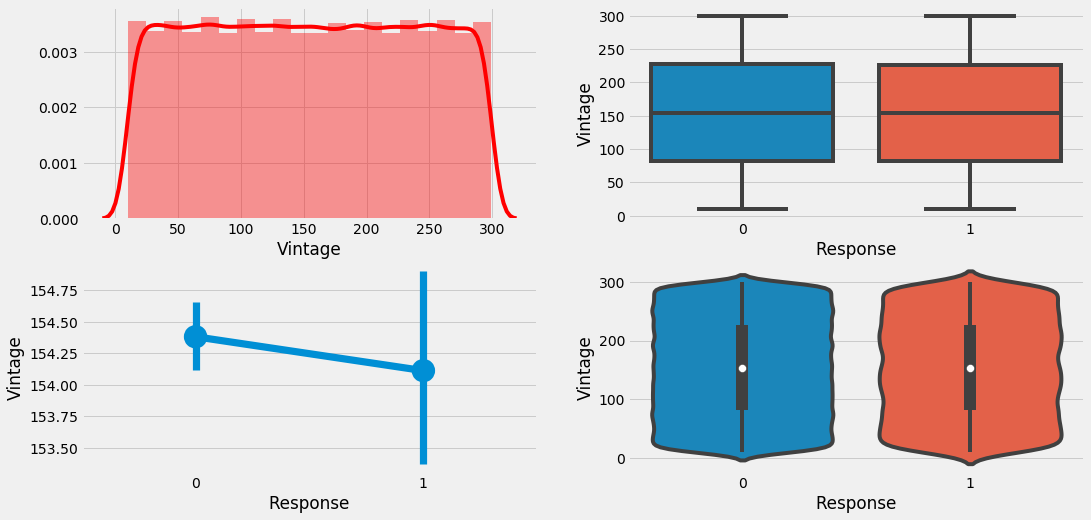

In [193]:
# Distribution Plot,BoxPlot,PointPlot and Violin Plot for Numerical Variable
fig,ax = plt.subplots(2,2,figsize=(16,8))
ax1,ax2,ax3,ax4 = ax.flatten()
sns.distplot(train['Vintage'],bins=20,color='r',ax=ax1)
sns.boxplot(y='Vintage',x='Response',data=train,ax=ax2)
sns.pointplot(y='Vintage',x='Response',data=train,ax=ax3)
sns.violinplot(y='Vintage',x='Response',data=train,ax=ax4)

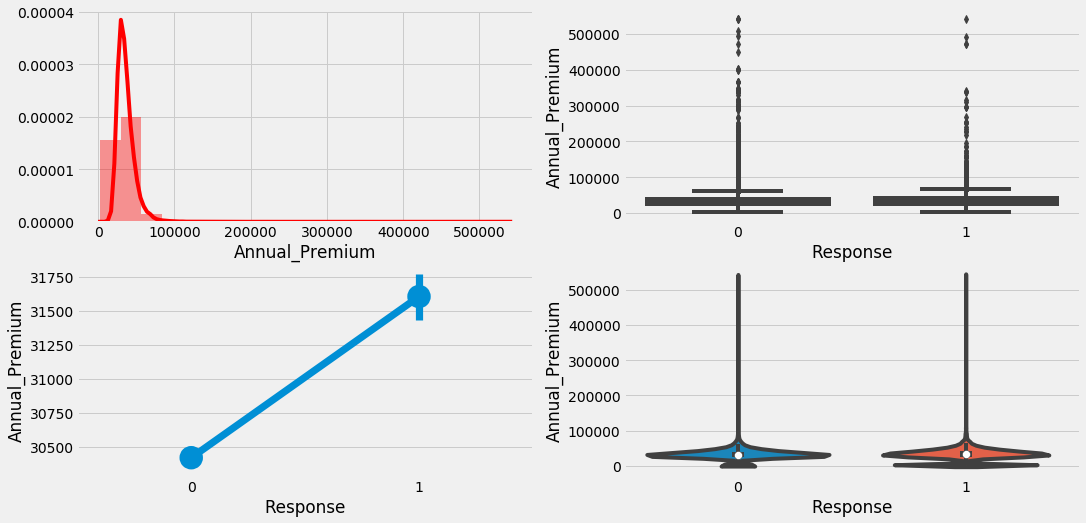

In [194]:
# Distribution Plot,BoxPlot,PointPlot and Violin Plot for Numerical Variable
fig,ax = plt.subplots(2,2,figsize=(16,8))
ax1,ax2,ax3,ax4 = ax.flatten()
sns.distplot(train['Annual_Premium'],bins=20,color='r',ax=ax1)
sns.boxplot(y='Annual_Premium',x='Response',data=train,ax=ax2)
sns.pointplot(y='Annual_Premium',x='Response',data=train,ax=ax3)
sns.violinplot(y='Annual_Premium',x='Response',data=train,ax=ax4)

In [239]:
# data['log_premium'] = np.log(data.Annual_Premium)
# data['log_age'] = np.log(data.Age)

In [268]:
# columns = ['id', 'Region_Code','Policy_Sales_Channel',
#        'Vintage', 'Response', 'Train', 'Gender_Female', 'Gender_Male',
#        'Vehicle_Age_1-2 Year', 'Vehicle_Age_< 1 Year', 'Vehicle_Age_> 2 Years',
#        'Vehicle_Damage_No', 'Vehicle_Damage_Yes', 'Driving_License_0',
#        'Driving_License_1', 'Previously_Insured_0', 'Previously_Insured_1',
#        'log_premium', 'log_age']

In [221]:
# train = data[data['Train'] == True].drop(['Train'],axis=1)
# test = data[data['Train'] == False].drop(['Train','Response'],axis=1)

In [222]:
# train.head()

,id,Region_Code,Policy_Sales_Channel,Vintage,Response,Gender_Female,Gender_Male,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_No,Vehicle_Damage_Yes,Driving_License_0,Driving_License_1,Previously_Insured_0,Previously_Insured_1,log_premium,log_age
0,1,28.0,26.0,217,1.0,0,1,0,0,1,0,1,0,1,1,0,10.607921,3.784190
1,2,3.0,26.0,183,0.0,0,1,1,0,0,1,0,0,1,1,0,10.420375,4.330733
2,3,28.0,26.0,27,1.0,0,1,0,0,1,0,1,0,1,1,0,10.553049,3.850148
3,4,11.0,152.0,203,0.0,0,1,0,1,0,1,0,0,1,0,1,10.261826,3.044522
4,5,41.0,152.0,39,0.0,1,0,0,1,0,1,0,0,1,0,1,10.221796,3.367296


In [289]:
X = train.drop(["id","Response"],axis=1)
y = train['Response']

In [209]:
# Annual_Premium_lower,Annual_Premium_upper = detect_outlier(train['Annual_Premium'])
# print(Annual_Premium_lower,Annual_Premium_upper)

In [210]:
# #Imputing the outliers
# train.loc[train['Annual_Premium'] > Annual_Premium_upper,'Annual_Premium'] = Annual_Premium_upper
# train.loc[train['Annual_Premium'] < Annual_Premium_lower,'Annual_Premium'] = Annual_Premium_lower

In [211]:
# # Distribution Plot,BoxPlot,PointPlot and Violin Plot for Numerical Variable
# fig,ax = plt.subplots(2,2,figsize=(16,8))
# ax1,ax2,ax3,ax4 = ax.flatten()
# sns.distplot(train['Annual_Premium'],bins=20,color='r',ax=ax1)
# sns.boxplot(y='Annual_Premium',x='Response',data=train,ax=ax2)
# sns.pointplot(y='Annual_Premium',x='Response',data=train,ax=ax3)
# sns.violinplot(y='Annual_Premium',x='Response',data=train,ax=ax4)

Text(0.5, 0, 'Response')

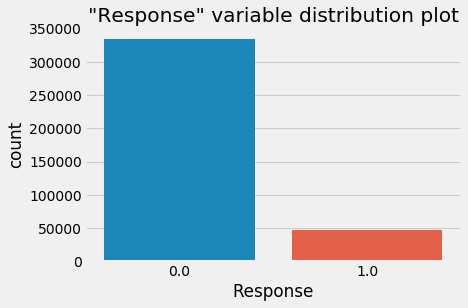

In [212]:
sns.countplot(train['Response'])
plt.title('"Response" variable distribution plot')
plt.xlabel('Response')

In [224]:
train.columns

Index(['id', 'Region_Code', 'Policy_Sales_Channel', 'Vintage', 'Response',
       'Gender_Female', 'Gender_Male', 'Vehicle_Age_1-2 Year',
       'Vehicle_Age_< 1 Year', 'Vehicle_Age_> 2 Years', 'Vehicle_Damage_No',
       'Vehicle_Damage_Yes', 'Driving_License_0', 'Driving_License_1',
       'Previously_Insured_0', 'Previously_Insured_1', 'log_premium',
       'log_age'],
      dtype='object')

In [225]:
# Apply regular SMOTE
sm = SMOTE()
X_SMOTE, y_SMOTE = sm.fit_sample(X, y)

Text(0.5, 0, 'Response')

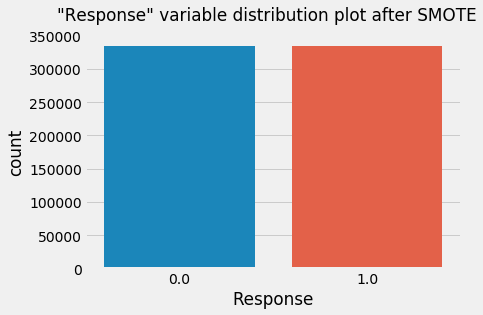

In [226]:
sns.countplot(y_SMOTE)
plt.suptitle('"Response" variable distribution plot after SMOTE')
plt.xlabel('Response')

In [227]:
# from imblearn.over_sampling import ADASYN
# X_ADASYN, y_ADASYN = ADASYN().fit_sample(X, y)

In [228]:
# sns.countplot(y_ADASYN)
# plt.suptitle('"Response" variable distribution plot after SMOTE')
# plt.xlabel('Response')

In [229]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=2020)

Name :  RAW
Model : Logistic Regression


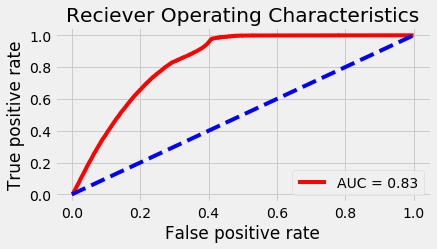

Name :  SMOTE
Model : Logistic Regression


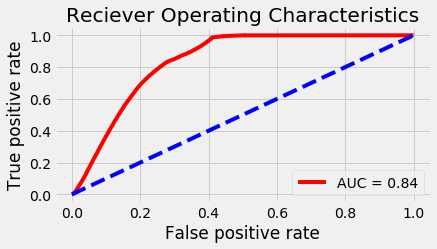

In [230]:
from sklearn import model_selection
skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(X_train, y_train)

for X,y,name in zip([X,X_SMOTE],[y,y_SMOTE],["RAW","SMOTE"]):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=2020)
    print("Name : " , name)
    print("Model : Logistic Regression")
    #     print("Model : Light GBM")
    #     from lightgbm import LGBMClassifier
    #     lg=LGBMClassifier(boosting_type='gbdt',n_estimators=500,depth=10,learning_rate=0.04,objective='binary',metric='auc',is_unbalance=True,
    #                  colsample_bytree=0.5,reg_lambda=2,reg_alpha=2,random_state=294,n_jobs=-1)

    #     lg.fit(X_train,y_train)
    #     plot_roc_curve(X_test,y_test,lg)
    #     save_predictions(lg,test,model_name="Light GBM_" + name)
    
    from sklearn import linear_model
    lr = linear_model.LogisticRegression(C=1000,solver='liblinear')
    lr.fit(X_train,y_train)
    prediction_lr = lr.predict(X_test)
    plot_roc_curve(X_test,y_test,lr)
    save_predictions(lr,test,model_name="Logistic Regression_" + name)
    

        #     print("Model : Random Forest")
        #     # RandomForest Classifier
        #     from sklearn.ensemble import RandomForestClassifier
        #     num_trees = 100
        #     rf = RandomForestClassifier(n_estimators=num_trees).fit(X_train, y_train)
        #     results = model_selection.cross_val_score(rf, X_train, y_train, cv=skf)
        #     plot_roc_curve(X_test,y_test,rf)
        #     save_predictions(rf,test,model_name="Random Forest_" + name)
    
#     print("Model : Xgboost")
#     from xgboost.sklearn import XGBClassifier
#     num_rounds = 100
#     xgb = XGBClassifier(n_estimators = num_rounds,objective= 'binary:logistic',seed=2020)
#     xgb.fit(X_train,y_train, early_stopping_rounds=20, eval_set=[(X_test,y_test)], verbose=False)
#     plot_roc_curve(X_test,y_test,xgb)
#     test_values = test.drop(['id'],axis=1).values
#     predictions = xgb.predict(test_values)
#     result = pd.DataFrame({'id':test['id'],'Response':np.ravel(predictions)})
#     result.to_csv("Xgboost_" + name + '_pred.csv', index=False)

In [290]:
X.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,1,44,1,28.0,0,2,1,40454.0,26.0,217
1,1,76,1,3.0,0,0,0,33536.0,26.0,183
2,1,47,1,28.0,0,2,1,38294.0,26.0,27
3,1,21,1,11.0,1,1,0,28619.0,152.0,203
4,0,29,1,41.0,1,1,0,27496.0,152.0,39


In [312]:
from imblearn.combine import SMOTETomek
os=SMOTETomek(0.75)
X_train_ns,y_train_ns=os.fit_sample(X,y)

C:\Users\sateesh.yavarna\AppData\Roaming\Python\Python37\site-packages\imblearn\utils\_validation.py:638: FutureWarning: Pass sampling_strategy=0.75 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning)


Text(0.5, 0.98, '"Response" variable distribution plot after SMOTE')

Text(0.5, 0, 'Response')

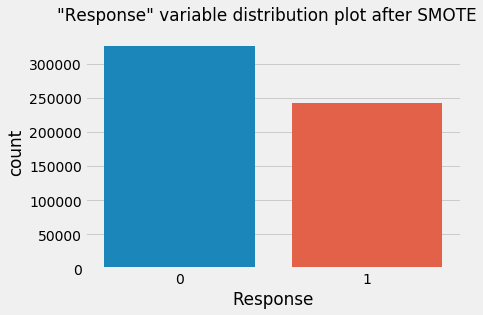

In [313]:
sns.countplot(y_train_ns)
plt.suptitle('"Response" variable distribution plot after SMOTE')
plt.xlabel('Response')

In [314]:
X_t, X_tt, y_t, y_tt = train_test_split(X_train_ns, y_train_ns, test_size=.25, random_state=2)

In [315]:
from lightgbm import LGBMClassifier
lgbcl = LGBMClassifier(n_estimators=52)
lgbcl= lgbcl.fit(X_t, y_t,eval_metric='auc',eval_set=(X_tt , y_tt),verbose=2,categorical_feature=cat_columns)
y_lgb = lgbcl.predict(X_tt)
probs_tr = lgbcl.predict_proba(X_t)[:, 1]
probs_te = lgbcl.predict_proba(X_tt)[:, 1]
roc_auc_score(y_t, probs_tr)
roc_auc_score(y_tt, probs_te)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Driving_License', 'Gender', 'Previously_Insured', 'Region_Code', 'Vehicle_Age', 'Vehicle_Damage']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[2]	valid_0's auc: 0.900665	valid_0's binary_logloss: 0.59821
[4]	valid_0's auc: 0.904931	valid_0's binary_logloss: 0.539768
[6]	valid_0's auc: 0.908037	valid_0's binary_logloss: 0.497184
[8]	valid_0's auc: 0.909496	valid_0's binary_logloss: 0.465384
[10]	valid_0's auc: 0.910572	valid_0's binary_logloss: 0.440958
[12]	valid_0's auc: 0.915516	valid_0's binary_logloss: 0.418923
[14]	valid_0's auc: 0.916945	valid_0's binary_logloss: 0.40312
[16]	valid_0's auc: 0.918007	valid_0's binary_logloss: 0.390755
[18]	valid_0's auc: 0.919292	valid_0's binary_logloss: 0.380475
[20]	valid_0's auc: 0.92159	valid_0's binary_logloss: 0.370427
[22]	valid_0's auc: 0.922963	valid_0's binary_logloss: 0.362744
[24]	valid_0's auc: 0.924445	valid_0's binary_logloss: 0.35566
[26]	valid_0's auc: 0.925522	valid_0's binary_logloss: 0.350004
[28]	valid_0's auc: 0.92657	valid_0's binary_logloss: 0.345267
[30]	valid_0's auc: 0.927243	valid_0's binary_logloss: 0.341838
[32]	valid_0's auc: 0.927903	valid_0's binary_log

0.9342933709863811

0.9344518267089152

In [317]:
lgbcl= lgbcl.fit(X_train_ns, y_train_ns)
lgb_pred= lgbcl.predict_proba(test.drop(['id'],axis=1))[:, 1]
sample_submission['Response']=lgb_pred
sample_submission.to_csv("lgb_SMOTETomek.csv", index = False)


In [236]:
# Stacking
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics

X_train, X_test, y_train, y_test = train_test_split(X_SMOTE, y_SMOTE, test_size=0.3,
random_state=2017)

skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(X_train, y_train)

num_trees = 10
verbose = True # to print the progress

clfs = [KNeighborsClassifier(),
        RandomForestClassifier(n_estimators=num_trees, random_state=2017),
        GradientBoostingClassifier(n_estimators=num_trees, random_state=2017)
       ]

#Creating train and test sets for blending
dataset_blend_train = np.zeros((X_train.shape[0], len(clfs)))
dataset_blend_test = np.zeros((X_test.shape[0], len(clfs)))

print('5-fold cross validation:\n')
for i, clf in enumerate(clfs):
    scores = model_selection.cross_val_score(clf, X_train, y_train, cv=skf,	scoring='roc_auc')
    print("##### Base Model %0.0f #####" % i)
    print("Train CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
    clf.fit(X_train, y_train)
    print("Train Accuracy: %0.2f " % (metrics.accuracy_score(clf.predict(X_train),	y_train)))
    dataset_blend_train[:,i] = clf.predict_proba(X_train)[:, 1]
    dataset_blend_test[:,i] = clf.predict_proba(X_test)[:, 1]
    print("Test Accuracy: %0.2f " % (metrics.accuracy_score(clf.predict(X_test),	y_test)))

print("##### Meta Model #####")
clf = LogisticRegression()
scores = model_selection.cross_val_score(clf, dataset_blend_train, y_train,cv=skf, scoring='roc_auc')
clf.fit(dataset_blend_train, y_train)
print("Train CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
print("Train Accuracy: %0.2f " % (metrics.accuracy_score(clf.predict(dataset_blend_train), y_train)))
print("Test Accuracy: %0.2f " % (metrics.accuracy_score(clf.predict(dataset_blend_test), y_test)))
            

5-fold cross validation:

##### Base Model 0 #####
Train CV Accuracy: 0.87 (+/- 0.00)
Train Accuracy: 0.89 
Test Accuracy: 0.84 
##### Base Model 1 #####
Train CV Accuracy: 0.96 (+/- 0.00)
Train Accuracy: 0.99 
Test Accuracy: 0.90 
##### Base Model 2 #####
Train CV Accuracy: 0.86 (+/- 0.00)
Train Accuracy: 0.81 
Test Accuracy: 0.81 
##### Meta Model #####
Train CV Accuracy: 1.00 (+/- 0.00)
Train Accuracy: 1.00 
Test Accuracy: 0.91 


In [302]:
def save_predictions(model,test,model_name):
    predictions = model.predict_proba(test.drop(['id'],axis=1))
    result = pd.DataFrame({'id':test['id'],'Response':predictions})
    result.to_csv(model_name + '_pred.csv', index=False)

[LightGBM] [Warning] Unknown parameter: depth


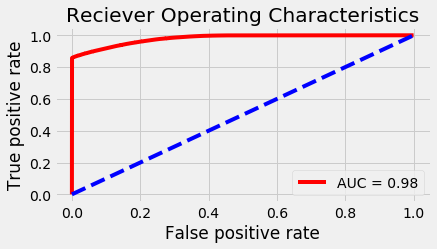

In [76]:
from lightgbm import LGBMClassifier
lg=LGBMClassifier(boosting_type='gbdt',n_estimators=500,depth=10,learning_rate=0.04,objective='binary',metric='auc',is_unbalance=True,
                 colsample_bytree=0.5,reg_lambda=2,reg_alpha=2,random_state=294,n_jobs=-1)

lg.fit(X_train,y_train)
plot_roc_curve(X_test,y_test,xgb)
# print(roc_auc_score(y_val,lg.predict_proba(X_val)[:,1]))

In [77]:
save_predictions(lg,test,model_name="Light GBM" + name)

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X_SMOTE, y_SMOTE, test_size=0.3,random_state=2020)

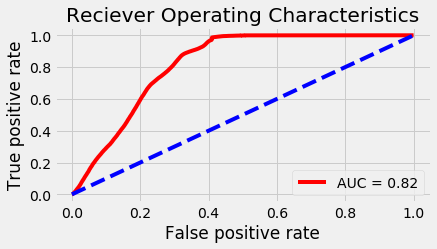

In [99]:
from sklearn import linear_model
lr = linear_model.LogisticRegression(C=1000,solver='liblinear')
lr.fit(X_train,y_train)
prediction_lr = lr.predict(X_test)
plot_roc_curve(X_test,y_test,lr)
# save_predictions(lr,test,model_name="Logistic Regression_l1_" + "SMOTE")


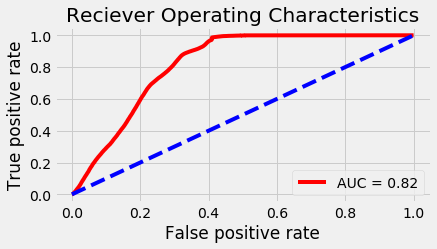

In [90]:
from sklearn import linear_model
lr = linear_model.LogisticRegression(C=1000,solver='liblinear',penalty="l2")
lr.fit(X_train,y_train)
prediction_lr = lr.predict(X_test)
plot_roc_curve(X_test,y_test,lr)
save_predictions(lr,test,model_name="Logistic Regression_l2_" + "SMOTE")


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


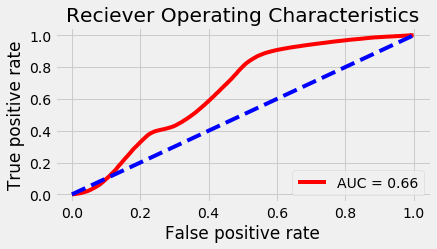

In [91]:
from sklearn import linear_model
lr = linear_model.LogisticRegression(C=1000,solver='saga',penalty="elasticnet",l1_ratio = 0.99)
lr.fit(X_train,y_train)
prediction_lr = lr.predict(X_test)
plot_roc_curve(X_test,y_test,lr)
save_predictions(lr,test,model_name="Logistic Regression_Elasticnet" + "SMOTE")


In [95]:
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier,EasyEnsembleClassifier
from imblearn.metrics import classification_report_imbalanced
from sklearn.model_selection import StratifiedShuffleSplit

In [96]:
model_bbag = BalancedBaggingClassifier(n_jobs=4, random_state=1, base_estimator=lr)
model_brf = BalancedRandomForestClassifier(n_jobs=4, random_state=1, class_weight='balanced')
model_easy = EasyEnsembleClassifier(n_jobs=4, random_state=1, base_estimator=lr)

imb_models = []
imb_models.append(('Bag', model_bbag))
imb_models.append(('BagRF', model_brf))
imb_models.append(('Easy', model_easy))

cv = StratifiedShuffleSplit(n_splits=5, random_state=1, train_size=0.8)

In [100]:
results_imb = []
names_imb = []
for name, model in imb_models:
    print("Training..."+name)
    scores = model_selection.cross_val_score(model, X, y, scoring='roc_auc', n_jobs=-1, cv = cv, verbose=0)
    results_imb.append(scores)
    names_imb.append(name)
    print("Model %s mean score : %.4f variance error: %.4f"%(name, np.mean(scores), np.std(scores)))

Training...Bag
Model Bag mean score : 0.6475 variance error: 0.0009
Training...BagRF
Model BagRF mean score : 0.9787 variance error: 0.0001
Training...Easy
Model Easy mean score : 0.6475 variance error: 0.0009


In [102]:
model_brf.fit(X, y)
model_easy.fit(X, y)

metrics_score(model_bbag, X, y)
metrics_score(model_brf, X, y)
metrics_score(model_easy, X, y)

pred_bbag = model_bbag.predict_proba(test_select)[:,1]
pred_brf = model_brf.predict_proba(test_select)[:,1]
pred_easy = model_easy.predict_proba(test_select)[:,1]

NameError: name 'metrics_score' is not defined

In [ ]:
save_predictions(lr,test,model_name="")

In [ ]:
submission(pred_bbag, 'imb_bbag')
submission(pred_brf, 'imb_brf')
submission(pred_easy, 'imb_easy')

pred_imb_stack = np.mean((pred_bbag, pred_brf, pred_easy), axis=0)
submission(pred_imb_stack, 'imb_stack')